In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from geoloaderfull import *

['all_sat_LLAHTR', 'all_uav_LLAHTR', 'all_uav_xyzHTR', 'match_array_40', 'sat300_image_paths', 'uav_image_paths']


In [3]:
tcities = ['atlanta','austin','boston','champaign','miami','sanfrancisco','springfield','stlouis']
vcities = ['chicago']
df = AerialCities(tcities, vcities).create_df()
df.head()

,uav,sat,label,is_valid
0,train/atlanta/uav-small/uav0.png,train/atlanta/sat-small/sat0.png,1,False
1,train/atlanta/uav-small/uav0.png,train/atlanta/sat-small/sat10.png,1,False
2,train/atlanta/uav-small/uav0.png,train/atlanta/sat-small/sat15.png,1,False
3,train/atlanta/uav-small/uav1.png,train/atlanta/sat-small/sat1.png,1,False
4,train/atlanta/uav-small/uav1.png,train/atlanta/sat-small/sat28.png,1,False


In [4]:
df[df['is_valid'] == True].head()

,uav,sat,label,is_valid
106478,train/chicago/uav-small/uav0.png,train/chicago/sat-small/sat0.png,1,True
106479,train/chicago/uav-small/uav0.png,train/chicago/sat-small/sat44.png,1,True
106480,train/chicago/uav-small/uav1.png,train/chicago/sat-small/sat1.png,1,True
106481,train/chicago/uav-small/uav2.png,train/chicago/sat-small/sat2.png,1,True
106482,train/chicago/uav-small/uav3.png,train/chicago/sat-small/sat3.png,1,True


In [5]:
mean, std = torch.tensor(imagenet_stats)
# for 3 channels
mean = mean[...,None,None]
std = std  [...,None,None]

## Custom itemlist

In [6]:
# The primary difference from the tutorial is with how normalization is being done here
class ImageTuple(ItemBase):
    def __init__(self, img1, img2):
        self.img1,self.img2 = img1,img2
        self.obj = (img1,img2)
        self.data = [(img1.data-mean)/std, (img2.data-mean)/std]
    def apply_tfms(self, tfms, **kwargs):
        self.img1 = self.img1.apply_tfms(tfms[0], **kwargs)
        self.img2 = self.img2.apply_tfms(tfms[1], **kwargs)
        self.data = [(self.img1.data-mean)/std, (self.img2.data-mean)/std]
        return self    
    def to_one(self): return Image(mean+torch.cat(self.data,2)*std)
    def __repr__(self): return f'{self.__class__.__name__} {self.img1.shape, self.img2.shape}'

In [7]:
class ImageTupleList(ImageList):
    def __init__(self, items, itemsB=None, **kwargs):
        super().__init__(items, **kwargs)
        self.itemsB = itemsB
        self.copy_new.append('itemsB')
    def get(self, i):
        img1 = super().get(i)
        fn = self.itemsB[i]
        return ImageTuple(img1, open_image(fn))
    
    @classmethod
    def from_dfs(cls, df:DataFrame, path='.', cols=0, colsB=1, **kwargs):
        "Create an `ItemList` in `path` from the inputs in the `cols` of `df`."
        t_itemsB = ImageList.from_df(df[df['is_valid']==False], path, colsB).items
        t_res = super().from_df(df[df['is_valid']==False],path,cols, itemsB=t_itemsB, **kwargs)
        v_itemsB = ImageList.from_df(df[df['is_valid']==True],  path, colsB).items
        v_res = super().from_df(df[df['is_valid']==True],path,cols, itemsB=v_itemsB, **kwargs)
        t_res.path = v_res.path = path
        return ItemLists(t_res.path, t_res, v_res)
       
    def reconstruct(self, t:Tensor): 
        return ImageTuple(Image(t[0]*std+mean),Image(t[1]*std+mean))
    def show_xys(self, xs, ys, figsize:Tuple[int,int]=(12,6), **kwargs):
        rows = int(math.sqrt(len(xs)))
        fig, axs = plt.subplots(rows,rows,figsize=figsize)
        for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
            xs[i].to_one().show(ax=ax, y=ys[i], **kwargs)
        plt.tight_layout()

    def show_xyzs(self, xs, ys, zs, figsize:Tuple[int,int]=None, **kwargs):
        """Show `xs` (inputs), `ys` (targets) and `zs` (predictions) on a figure of `figsize`.
        `kwargs` are passed to the show method."""
        figsize = ifnone(figsize, (12,3*len(xs)))
        fig,axs = plt.subplots(len(xs), 2, figsize=figsize)
        fig.suptitle('Ground truth / Predictions', weight='bold', size=14)
        for i,(x,z) in enumerate(zip(xs,zs)):
            x.to_one().show(ax=axs[i,0], **kwargs)
            z.to_one().show(ax=axs[i,1], **kwargs)

## Create a databunch

In [8]:
target_col = 2
is_valid_col = 3
bs = 64
data = (ImageTupleList.from_dfs(df, path='.', cols=0, colsB=1)
         .label_from_df(cols=target_col, label_cls=FloatList)
         .databunch(bs=bs))

### Define transforms for random multiple 90 degree rotations

In [9]:
def _rot90_affine(k:partial(uniform_int, 0, 3)):
# adapted from kechan's implementation, see fastai/fastai issue #1653
    "Randomly rotate `x` image based on `k` as in np.rot90"
    #print("k={}".format(k))
    if k%2 == 0:
        x = -1. if k&2 else 1.
        y = -1. if k&2 else 1.
        
        return [[x, 0, 0.],
                [0, y, 0],
                [0, 0, 1.]]
    else:
        x = 1. if k&2 else -1.
        y = -1. if k&2 else 1.
        
        return [[0, x, 0.],
                [y, 0, 0],
                [0, 0, 1.]]

rot90_affine = RandTransform(tfm=TfmAffine(_rot90_affine),
                            kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True)

In [10]:
# allowing mirroring for better generalization
tfms_uav = get_transforms(do_flip=True, flip_vert=False)
tfms_sat = get_transforms(do_flip=True, flip_vert=True, 
                          max_warp=None, xtra_tfms=[rot90_affine])

In [11]:
data.train_ds.tfms = [tfms_uav[0], tfms_sat[0]]
data.valid_ds.tfms = [tfms_uav[1], tfms_sat[1]]

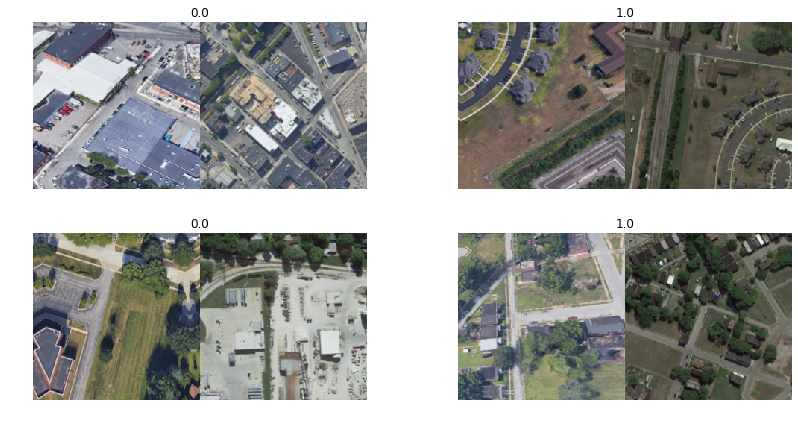

In [12]:
data.show_batch(2, DatasetType.Train)

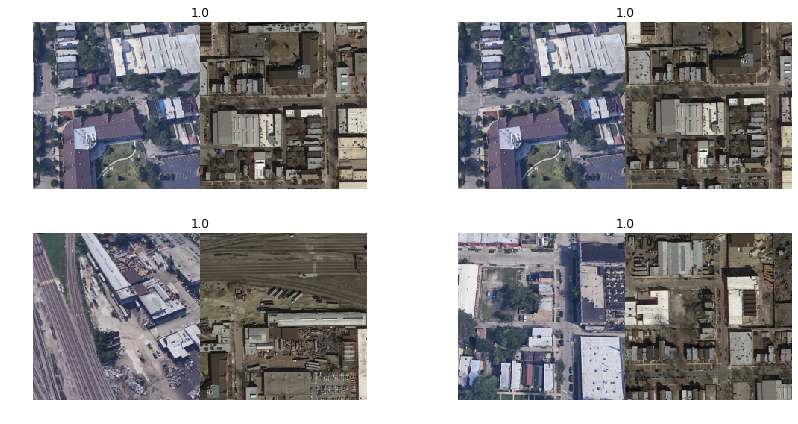

In [13]:
data.show_batch(2, DatasetType.Valid)

## Model 

In [14]:
class DualResNet18(nn.Module):
    def __init__(self, arch = models.resnet18):
        super().__init__()
        self.GEcnn  = create_body(arch)
        self.GEhead = nn.Sequential(AdaptiveConcatPool2d(1), 
                                    Flatten(),
                                    nn.BatchNorm1d(1024),
                                    nn.Dropout(p=0.25, inplace=False),
                                    nn.Linear(in_features=1024, out_features=512, bias=True),
                                    nn.ReLU(inplace=True),
                                    nn.BatchNorm1d(512),
                                    nn.Dropout(p=0.5, inplace=False),
                                    nn.Linear(in_features=512, out_features=512, bias=True))     
        self.GMcnn  = create_body(arch)
        self.GMhead = nn.Sequential(AdaptiveConcatPool2d(1), 
                                    Flatten(),
                                    nn.BatchNorm1d(1024),
                                    nn.Dropout(p=0.25, inplace=False),
                                    nn.Linear(in_features=1024, out_features=512, bias=True),
                                    nn.ReLU(inplace=True),
                                    nn.BatchNorm1d(512),
                                    nn.Dropout(p=0.5, inplace=False),
                                    nn.Linear(in_features=512, out_features=512, bias=True))
        
    def forward(self, img1, img2):
        o1 = self.GEhead(self.GEcnn(img1))
        o2 = self.GMhead(self.GMcnn(img2))
        output = torch.norm(o1-o2, p=2, dim=1)
        return output

## Loss 

In [15]:
def loss_contrastive(euclidean_distance, label_batch):
    margin = 100
    loss = torch.mean( (label_batch) * torch.pow(euclidean_distance, 2) +
                    (1-label_batch) * torch.pow(torch.clamp(margin - euclidean_distance, min=0.0), 2))
    return loss

## Accuracy metric 

In [16]:
def accuracy(input:Tensor, targs:Tensor)->Rank0Tensor:
    "Computes accuracy with `targs` when `input` is bs"
    input = input<50
    return (input==targs).float().mean()

## Learn 

In [17]:
model = DualResNet18()
learn = Learner(data, model, loss_func=loss_contrastive, metrics=accuracy)

In [18]:
learn.split([[learn.model.GEcnn[:6], learn.model.GMcnn[:6]], 
             [learn.model.GEcnn[6:], learn.model.GMcnn[6:]],
             [learn.model.GEhead,    learn.model.GMhead]])
learn.freeze_to(-2)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.37E-05
Min loss divided by 10: 1.32E-03


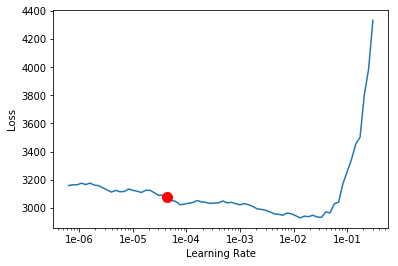

In [19]:
learn.lr_find()
learn.recorder.plot(suggestion = True)

In [20]:
learn.fit_one_cycle(10, slice(3e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1245.668213,1998.891235,0.708636,17:39
1,1279.898071,2113.939453,0.686541,17:05
2,1167.697632,1826.681274,0.729212,19:45
3,1058.887451,2029.521851,0.690251,17:03
4,974.478149,2700.334473,0.579018,20:02
5,921.748596,1838.721191,0.722297,18:49
6,812.858093,1823.519287,0.718081,17:02
7,783.083557,1972.745850,0.699022,18:37
8,751.152222,1948.323853,0.703997,17:20
9,750.703613,1944.607178,0.707033,18:20


In [21]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


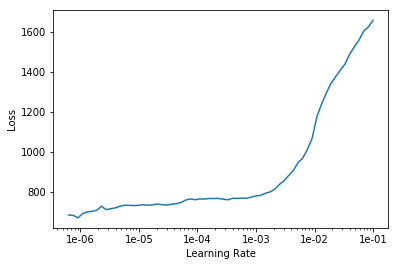

In [22]:
learn.lr_find()
learn.recorder.plot()

In [23]:
learn.fit_one_cycle(10, slice(1e-6))

epoch,train_loss,valid_loss,accuracy,time
0,719.302185,1826.297852,0.725417,29:55
1,727.381775,1991.685669,0.700371,35:26
2,704.412537,1897.524536,0.715045,36:21
3,706.073120,1792.982910,0.730983,35:26
4,721.367798,1797.420776,0.727526,36:07
5,711.832153,2056.821533,0.689155,37:11
6,753.393250,1939.677490,0.709900,36:13
7,748.922607,1837.877563,0.724237,36:03
8,750.195007,2030.502808,0.691179,35:48
9,733.360535,1856.338135,0.718165,34:23


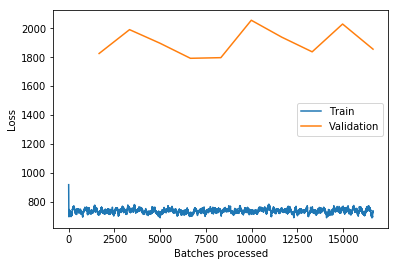

In [24]:
learn.recorder.plot_losses()

In [25]:
preds = learn.get_preds(DatasetType.Train)
len(preds), preds[0].shape, preds

(2,
 torch.Size([106432]),
 [tensor([ 11.7751,  33.7242, 111.2683,  ...,  90.8470,  54.4432, 121.7196]),
  tensor([1., 1., 0.,  ..., 0., 1., 0.])])

In [26]:
v_preds = learn.get_preds(DatasetType.Valid)
len(v_preds), v_preds[0].shape, v_preds

(2,
 torch.Size([11858]),
 [tensor([ 66.9296,  54.7902,   5.1824,  ...,  47.4774, 119.6604, 171.5786]),
  tensor([1., 1., 1.,  ..., 0., 0., 0.])])

In [27]:
def histo(preds, dset):
    matdist, nmatdist = [], []
    for i in range(len(preds[0])):
        if preds[1][i] == 0: nmatdist.append(preds[0][i].numpy())
        if preds[1][i] == 1: matdist. append(preds[0][i].numpy())

    mathist  = plt.hist( matdist, range(int(np.ceil(max( matdist)))), label = 'matching pairs', alpha = 0.7)
    nmathist = plt.hist(nmatdist, range(int(np.ceil(max(nmatdist)))), label = 'non-matching pairs', alpha = 0.7)
    plt.legend(loc='best')
    plt.title(dset + ' data')
    plt.xlabel('Distance between image pairs')
    plt.show()

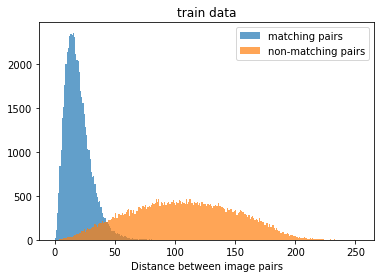

In [28]:
histo(preds, 'train')

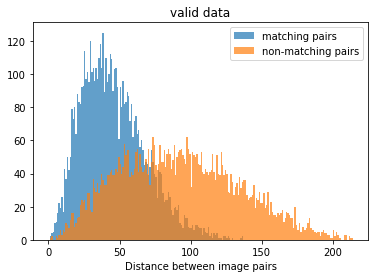

In [30]:
histo(v_preds, 'valid')

In [31]:
learn.save('05_allcities_prev_best_approach')